In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

In [59]:
import keras_tuner as kt
from keras_tuner import RandomSearch

In [60]:
from collections import Counter

In [61]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error

In [62]:
from matplotlib.ticker import MaxNLocator

In [63]:
import relative_accuracy as ra
import MVA as ga
import geh as ga1
from statistics import mean, stdev

In [64]:
# Load all Inputs and Output Data

# 5 mins (1 step ahead)
Deep_train_5   = np.load("Deep_train_5.npz")['x'] 
Output_train_5 = np.load("Deep_train_5.npz")['y']

Deep_test_5   = np.load("Deep_test_5.npz")['x'] 
Output_test_5 = np.load("Deep_test_5.npz")['y'] 

# 15 mins (3 steps ahead)
Deep_train_15   = np.load("Deep_train_15.npz")['x'] 
Output_train_15 = np.load("Deep_train_15.npz")['y']

Deep_test_15   = np.load("Deep_test_15.npz")['x'] 
Output_test_15 = np.load("Deep_test_15.npz")['y']

# 30 mins (6 steps ahead)
Deep_train_30   = np.load("Deep_train_30.npz")['x'] 
Output_train_30 = np.load("Deep_train_30.npz")['y']

Deep_test_30   = np.load("Deep_test_30.npz")['x'] 
Output_test_30 = np.load("Deep_test_30.npz")['y']

# 60 mins (12 steps ahead)
Deep_train_60   = np.load("Deep_train_60.npz")['x'] 
Output_train_60 = np.load("Deep_train_60.npz")['y']

Deep_test_60   = np.load("Deep_test_60.npz")['x'] 
Output_test_60 = np.load("Deep_test_60.npz")['y']

In [65]:
# Wide Data
Xtrain = joblib.load("002weeks_train.save") 
Xtest = joblib.load("002weeks_test.save") 

In [66]:
# 5 mins
# Delete first 15 samples
Wide_train_5 = np.delete(Xtrain, np.s_[0:15], 0)
Wide_test_5 = np.delete(Xtest, np.s_[0:15], 0)

In [67]:
# 15 mins
# Delete first 17 samples
Wide_train_15 = np.delete(Xtrain, np.s_[0:17], 0)
Wide_test_15 = np.delete(Xtest, np.s_[0:17], 0)

In [68]:
# 30 mins
# Delete first 20 samples
Wide_train_30 = np.delete(Xtrain, np.s_[0:20], 0)
Wide_test_30 = np.delete(Xtest, np.s_[0:20], 0)

In [69]:
# 60 mins
# Delete first 27 samples
Wide_train_60 = np.delete(Xtrain, np.s_[0:26], 0)
Wide_test_60 = np.delete(Xtest, np.s_[0:26], 0)

In [70]:
scaler_filename = "scaler.save"
scaler = joblib.load(scaler_filename) 

In [71]:
Test      = pd.read_csv('01test_scaled.csv', index_col=None, parse_dates=[0])

In [72]:
# plt.rcParams.update({'font.size': 24})

# Reshape Samples

The first step is to split the input sequences into subsequences that can be processed by the CNN model. Here, each spatio-temporal sample can be split into three sub-samples, each with five time steps. The CNN can interpret each subsequence of five time steps and provide a time series of interpretations of the subsequences to the LSTM model to process as input.

In [73]:
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 6              # No of loop detectors
n_seq = 3                    # Subsequences
n_steps = 5                  # time-step per subsequence
val_percent = 0.07567        # 2 weeks
batch_size = 32

#### 5 mins

In [74]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt5 = Deep_train_5.reshape((Deep_train_5.shape[0], n_seq, n_steps, n_features))
yt5 = Output_train_5

In [75]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv5 = Deep_test_5.reshape((Deep_test_5.shape[0], n_seq, n_steps, n_features))
yv5 = Output_test_5

#### 15 mins

In [76]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt15 = Deep_train_15.reshape((Deep_train_15.shape[0], n_seq, n_steps, n_features))
yt15 = Output_train_15

In [77]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv15 = Deep_test_15.reshape((Deep_test_15.shape[0], n_seq, n_steps, n_features))
yv15 = Output_test_15

#### 30 mins

In [78]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt30 = Deep_train_30.reshape((Deep_train_30.shape[0], n_seq, n_steps, n_features))
yt30 = Output_train_30

In [79]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv30 = Deep_test_30.reshape((Deep_test_30.shape[0], n_seq, n_steps, n_features))
yv30 = Output_test_30

#### 60 mins

In [80]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt60 = Deep_train_60.reshape((Deep_train_60.shape[0], n_seq, n_steps, n_features))
yt60 = Output_train_60

In [81]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv60 = Deep_test_60.reshape((Deep_test_60.shape[0], n_seq, n_steps, n_features))
yv60 = Output_test_60

### Reshaping the Data for Conv2D layer

For Conv2D, there is a need to add one more dimension to show we're dealing with 1 channel (since technically the images are in black and white, only showing values from 0-max flow on a single channel).

Conv1D - strides in 1 dimension
Conv2D - strides in 2 dimensions

In [82]:
# define no_of_channels
n_channels = 1

In [83]:
# Train data
Xt5  =  Xt5.reshape(Xt5.shape[0], n_seq, n_steps, n_features, n_channels)
Xt15 =  Xt15.reshape(Xt15.shape[0], n_seq, n_steps, n_features, n_channels)
Xt30 =  Xt30.reshape(Xt30.shape[0], n_seq, n_steps, n_features, n_channels)
Xt60 =  Xt60.reshape(Xt60.shape[0], n_seq, n_steps, n_features, n_channels)

# Validation data
Xv5  =  Xv5.reshape(Xv5.shape[0], n_seq, n_steps, n_features, n_channels)
Xv15 =  Xv15.reshape(Xv15.shape[0], n_seq, n_steps, n_features, n_channels)
Xv30 =  Xv30.reshape(Xv30.shape[0], n_seq, n_steps, n_features, n_channels)
Xv60 =  Xv60.reshape(Xv60.shape[0], n_seq, n_steps, n_features, n_channels)

In [84]:
Wt5  = Wide_train_5
Wt15 = Wide_train_15
Wt30 = Wide_train_30
Wt60 = Wide_train_60

Wv5  = Wide_test_5
Wv15 = Wide_test_15
Wv30 = Wide_test_30
Wv60 = Wide_test_60

# CNN-LSTM model

In [85]:
from tensorflow import keras

## 5 mins ahead

In [86]:
model5 = keras.models.load_model("my_dir/7d-CNN-LSTM-5") 

### Evaluation on inverse_transform

In [87]:
test_predictions5 = model5.predict((Wv5,Xv5))

yv5 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
yv5 = yv5[15:,3]

df = Test.drop(Test.head(15).index)
df.reset_index(inplace = True)
df = df.drop(columns=['index','Timestamp'])
df['f4'] = pd.Series(test_predictions5.flatten())

test_predictions5 = scaler.inverse_transform(df)

test_predictions5 = test_predictions5[:,3]

In [88]:
RA10 = ra.RA_10(np.asarray(yv5), np.asarray(test_predictions5))
RA15 = ra.RA_15(np.asarray(yv5), np.asarray(test_predictions5))
RA20 = ra.RA_20(np.asarray(yv5), np.asarray(test_predictions5))

res5 = [RA10, RA15, RA20]
print(res5)

[62.733383121732636, 79.71122728404282, 88.57356235997013]


In [89]:
GEH, num, actual, predicted = ga.GEH(np.asarray(yv5), np.asarray(test_predictions5))
GEH1, _ = ga1.GEH(np.asarray(yv5), np.asarray(test_predictions5))

In [90]:
GEH = np.pad(GEH[:273], (15,0), 'constant', constant_values=(np.nan, np.nan))
GEH1 = np.pad(GEH1[:273], (15,0), 'constant', constant_values=(np.nan, np.nan))

In [91]:
actual = np.pad(actual, (1, 1), 'edge')
predicted = np.pad(predicted, (1, 1), 'edge')

In [92]:
x = np.arange(1,len(GEH)+1)
x1 = np.arange(0,len(GEH1))

In [93]:
yv5 = np.pad(yv5[:273], (15,0), 'constant', constant_values=(np.nan, np.nan))
test_predictions5 = np.pad(test_predictions5[:273], (15,0), 'constant', constant_values=(np.nan, np.nan))
actual = np.pad(actual[:273], (15,0), 'constant', constant_values=(np.nan, np.nan))
predicted = np.pad(predicted[:273], (15,0), 'constant', constant_values=(np.nan, np.nan))

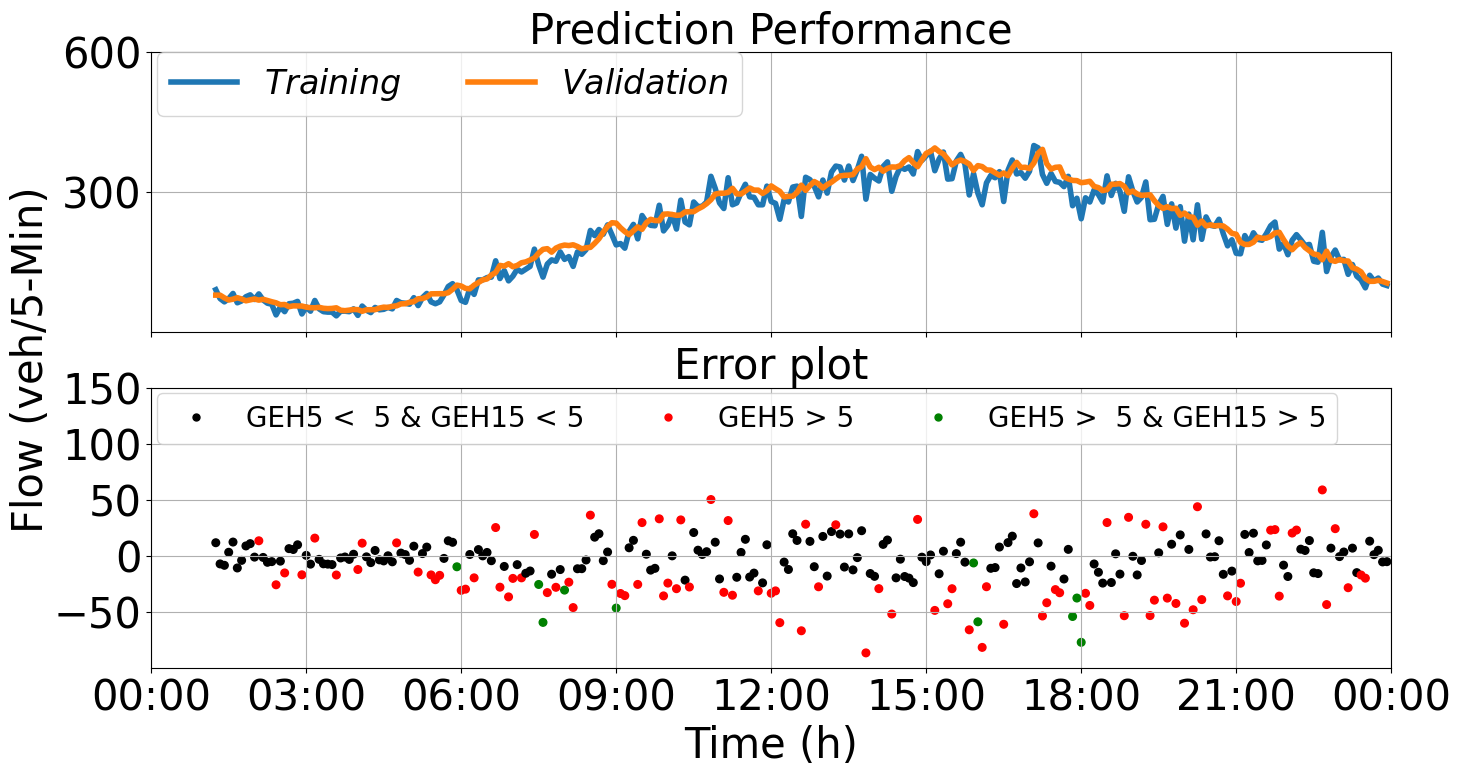

In [94]:
x= np.arange(0,288)
col = np.where(GEH>5, 'g', np.where(GEH1>5, 'r','k'))

fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(16,8))

#set tick labels font size for y-axis only
# axes.tick_params(axis='y', which='both', labelsize=20)

# 1 Prediction plot
axes[0].plot(yv5, lw=4, label=r'$Training$')
axes[0].plot(test_predictions5, lw=4, label=r'$Validation$')
axes[0].legend(bbox_to_anchor=(0.005,0.77,0.4,0.1), loc="lower left", mode=None, 
               borderaxespad=0, ncol=4, prop={'size': 24})
axes[0].set_title('Prediction Performance', fontsize=30)
axes[0].grid()
# x
axes[0].set_xlim(0,288)
axes[0].set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes[0].set_xticklabels([])
# y
axes[0].set_ylim(0,600)
axes[0].set_ylabel('Flow (veh/5-Min)', fontsize=30)
axes[0].yaxis.set_major_locator(MaxNLocator(nbins=2, prune='lower'))
axes[0].yaxis.set_label_coords(-0.08,-0.1)
axes[0].tick_params(axis='y', labelsize= 30)



# 2 Error plot
axes[1].scatter(x, (yv5-test_predictions5), s=30, c=col)
line1, = axes[1].plot(0, 0, marker="o", markersize=0.01, markeredgecolor="black", 
                      markerfacecolor="black", label='GEH5 <  5 & GEH15 < 5', ls="None")
line2, = axes[1].plot(0, 0, marker="o", markersize=0.01, markeredgecolor="red", 
                      markerfacecolor="red", label='GEH5 > 5', ls="None")
line3, = axes[1].plot(0, 0, marker="o", markersize=0.01, markeredgecolor="green", 
                      markerfacecolor="green", label='GEH5 >  5 & GEH15 > 5', ls="None")
axes[1].legend(handles=[line1, line2, line3], markerscale=500, bbox_to_anchor=(0.005,0.8,1,0.1), 
               loc="lower left", mode=None, borderaxespad=0, ncol=3, prop={'size': 20})
axes[1].set_title('Error plot', fontsize=30)
axes[1].grid()

# x
axes[1].set_xlim(0,288)
axes[1].set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes[1].set_xticklabels(['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00','00:00'], fontsize=30)
axes[1].set_xlabel('Time (h)', fontsize=30)
#y
axes[1].set_ylim(-100, 150)
axes[1].yaxis.set_major_locator(MaxNLocator(nbins=6, prune='lower'))
axes[1].tick_params(axis='y', labelsize= 30)


plt.show()

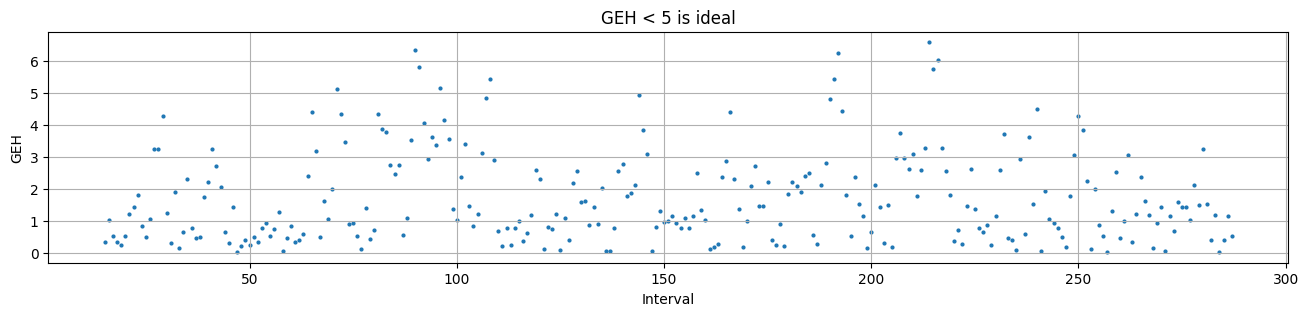

In [95]:
# Use similar to plt.figure() except use tuple unpacking to grab fig and axes
fig, axes = plt.subplots(figsize=(16,3))

# Now use the axes object to add stuff to plot
axes.scatter(x, GEH, 4)
axes.set_xlabel('Interval')
axes.set_ylabel('GEH')
axes.set_title('GEH < 5 is ideal')
axes.grid()

In [96]:
GEH5 = num/len(GEH)

## GEH bounds

In [97]:
import math

In [98]:
x_a = np.arange(0, len(yv5), 1)

In [99]:
x = yv5 * 12

In [100]:
a = -2
b = 4*x + 25
c = (-25*x + 2*x**2)*-1

d = b**2-4*a*c # discriminant

lst1 = []
lst2 = []

for i in range(len(d)):
    if d[i] < 0:
        lst1.append(np.nan)
        lst2.append(np.nan)
    elif d[i] == 0:
        lst1.append(np.nan)
        lst2.append(np.nan)
    else:
        xa = (-b[i]+math.sqrt((b[i]**2)-(4*(a*c[i]))))/(2*a)
        xb = (-b[i]-math.sqrt((b[i]**2)-(4*(a*c[i]))))/(2*a)
        lst1.append(xa)
        lst2.append(xb)

In [101]:
lst1 = np.array(lst1)/12
lst2 = np.array(lst2)/12

In [102]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# Figure

In [103]:
col = np.where(GEH>5, 'm','b')
col1 = np.where(GEH1>5, 'r','b')

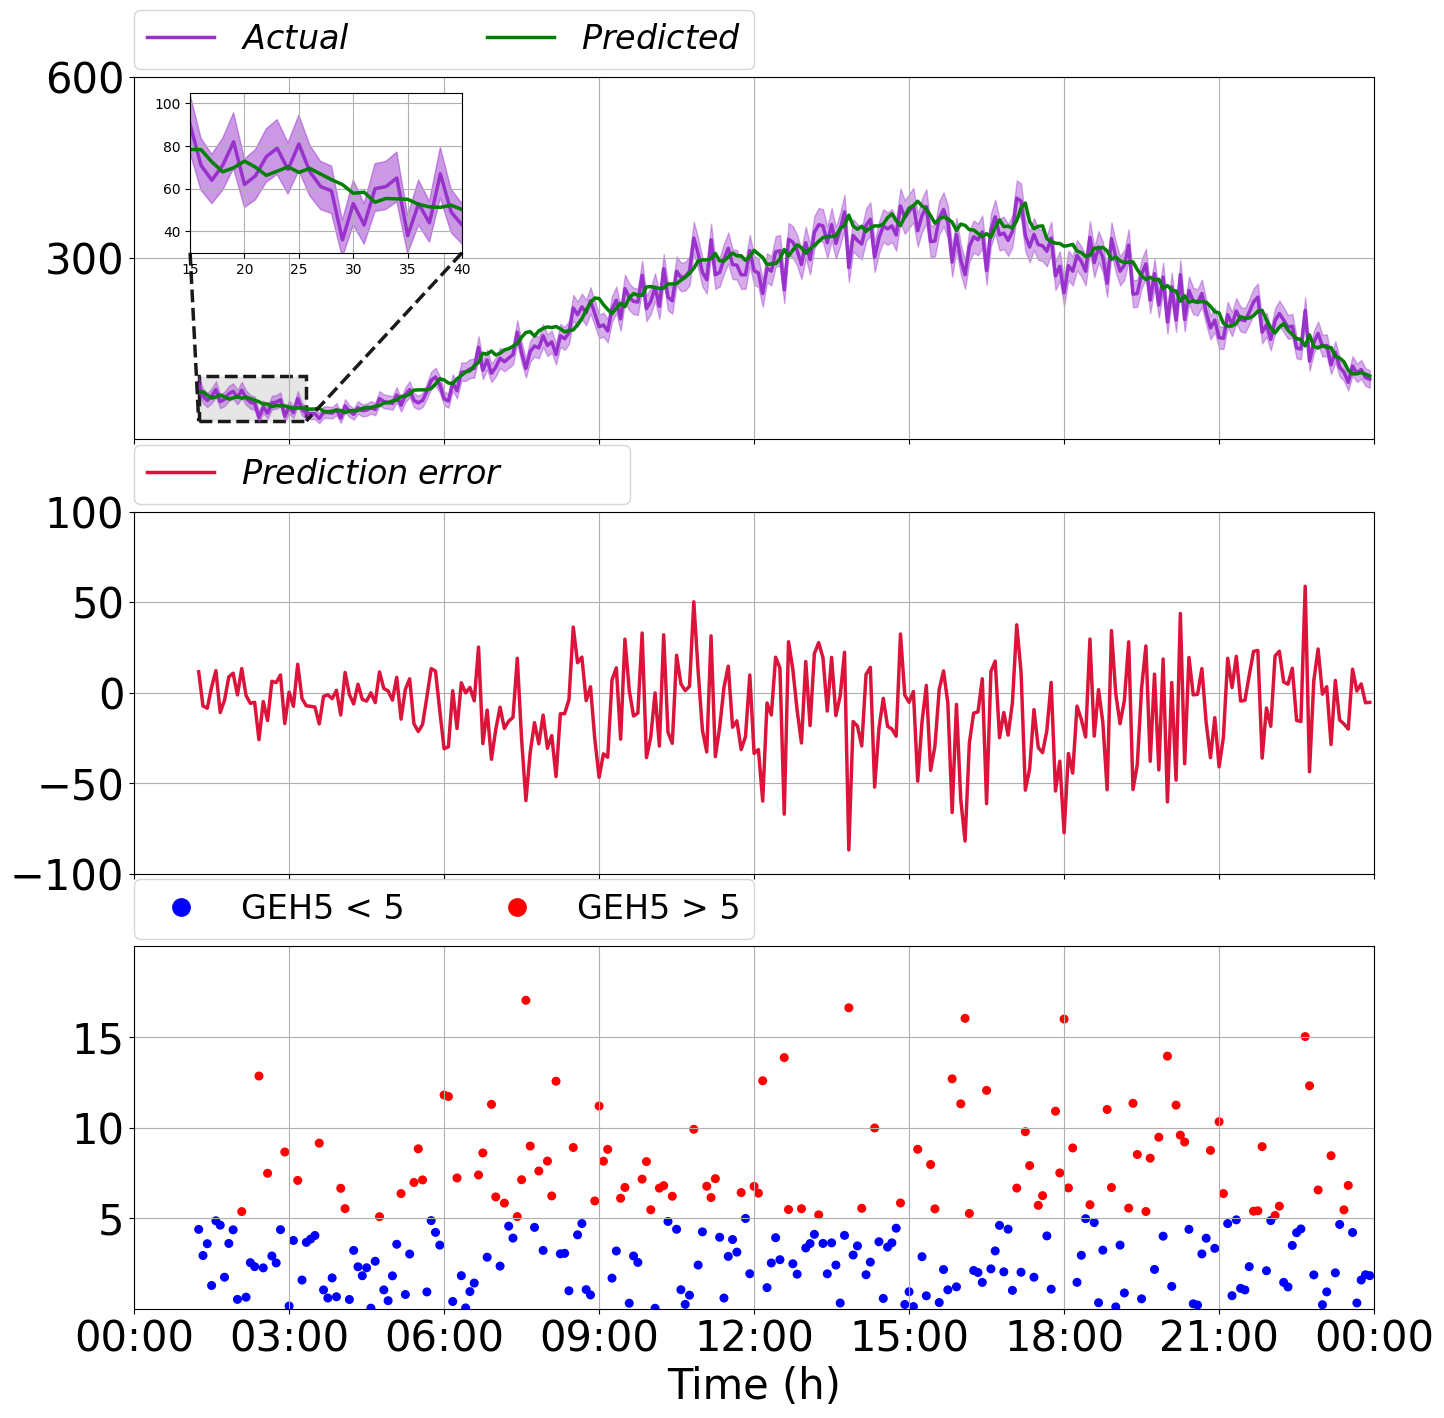

In [104]:
fig,axes = plt.subplots(nrows=3,ncols=1,figsize=(16,16))


# 1 Prediction plot
axes2 = fig.add_axes([0.16, 0.77, 0.17, 0.1]) # Smaller figure
axes2.plot(yv5, lw=2.5, label=r'$Actual$', color='darkorchid')
axes2.fill_between(x_a, lst1, lst2, alpha = .5, color = 'darkorchid')
axes2.plot(test_predictions5, lw=2.5, label=r'$Predicted$', color='green')
axes2.set_xlim(15,40)
axes2.set_ylim(30,105)
axes2.grid()
mark_inset(axes[0], axes2, loc1=3, loc2=4, fc="0.9", ec="0.1", ls='--', lw=2.5)

axes[0].plot(yv5, lw=2.5, label=r'$Actual$', color='darkorchid')
axes[0].fill_between(x_a, lst1, lst2, alpha = .4, color = 'darkorchid')
axes[0].plot(test_predictions5, lw=2.5, label=r'$Predicted$', color='green')

axes[0].legend(bbox_to_anchor=(0,1.02,0.5,0.6), loc="lower left", mode="expand", borderaxespad=0, ncol=2, prop={'size': 24})
axes[0].grid()
# x
axes[0].set_xlim(0,288)
axes[0].set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes[0].set_xticklabels([])
# y
axes[0].set_ylim(0,600)
# axes[0].set_ylabel('Flow (veh/5-Min)', fontsize=30)
axes[0].yaxis.set_major_locator(MaxNLocator(nbins=2, prune='lower'))
axes[0].yaxis.set_label_coords(-0.07,-0.1)



# 2 Error plot
axes[1].plot((yv5-test_predictions5), lw=2.5, label=r'$Prediction \; error$', color='crimson')
axes[1].legend(bbox_to_anchor=(0,1.02,0.4,0.6), loc="lower left", mode="expand", borderaxespad=0, ncol=2, prop={'size': 24})
axes[1].grid()
# x
axes[1].set_xlim(0,288)
axes[1].set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes[1].set_xticklabels([])
#y
axes[1].set_ylim(-100, 100)



# 3 GEH5 plot
axes[2].grid()
axes[2].scatter(x1[:288], GEH1, s=30, c=col1)
line1, = axes[2].plot(0, 0, marker="o", markersize=0.025, markeredgecolor="blue", 
                      markerfacecolor="blue", label='GEH5 < 5', ls="None")
line2, = axes[2].plot(0, 0, marker="o", markersize=0.025, markeredgecolor="red", 
                      markerfacecolor="red", label='GEH5 > 5', ls="None")
axes[2].legend(handles=[line1, line2], markerscale=500, bbox_to_anchor=(0,1.02,0.5,0.1), 
               loc="lower left", mode="expand", borderaxespad=0, ncol=2, prop={'size': 24})
# x
axes[2].set_xlim(0,288)
axes[2].set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes[2].set_xticklabels([])
# y
axes[2].yaxis.set_major_locator(MaxNLocator(nbins=4, prune='both', steps=[5]))
# axes[2].set_ylabel('GEH', fontsize=30)
axes[2].set_ylim(0,20)
axes[2].yaxis.set_label_coords(-0.07,0.5)
axes[2].set_xticklabels(['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00','00:00'], fontsize=30)
axes[2].set_xlabel('Time (h)', fontsize=30)

axes[0].tick_params(axis='y', labelsize= 30)
axes[1].tick_params(axis='y', labelsize= 30)
axes[2].tick_params(axis='y', labelsize= 30)
# plt.xticks(fontsize= 20)
# plt.yticks(fontsize= 20)

## Predictions Plot

In [105]:
x_a = np.arange(0, len(test_predictions5), 1)

In [106]:
x = test_predictions5 * 12

In [107]:
a = -2
b = 4*x + 25
c = (-25*x + 2*x**2)*-1

d = b**2-4*a*c # discriminant

lst1 = []
lst2 = []

for i in range(len(d)):
    if d[i] < 0:
        lst1.append(np.nan)
        lst2.append(np.nan)
    elif d[i] == 0:
        lst1.append(np.nan)
        lst2.append(np.nan)
    else:
        xa = (-b[i]+math.sqrt((b[i]**2)-(4*(a*c[i]))))/(2*a)
        xb = (-b[i]-math.sqrt((b[i]**2)-(4*(a*c[i]))))/(2*a)
        lst1.append(xa)
        lst2.append(xb)

In [108]:
lst1 = np.array(lst1)/12
lst2 = np.array(lst2)/12

In [109]:
col = np.where(GEH>5, 'm','b')
col1 = np.where(GEH1>6, 'r','b')
col2 = np.where(GEH1>16.6, 'r','b')

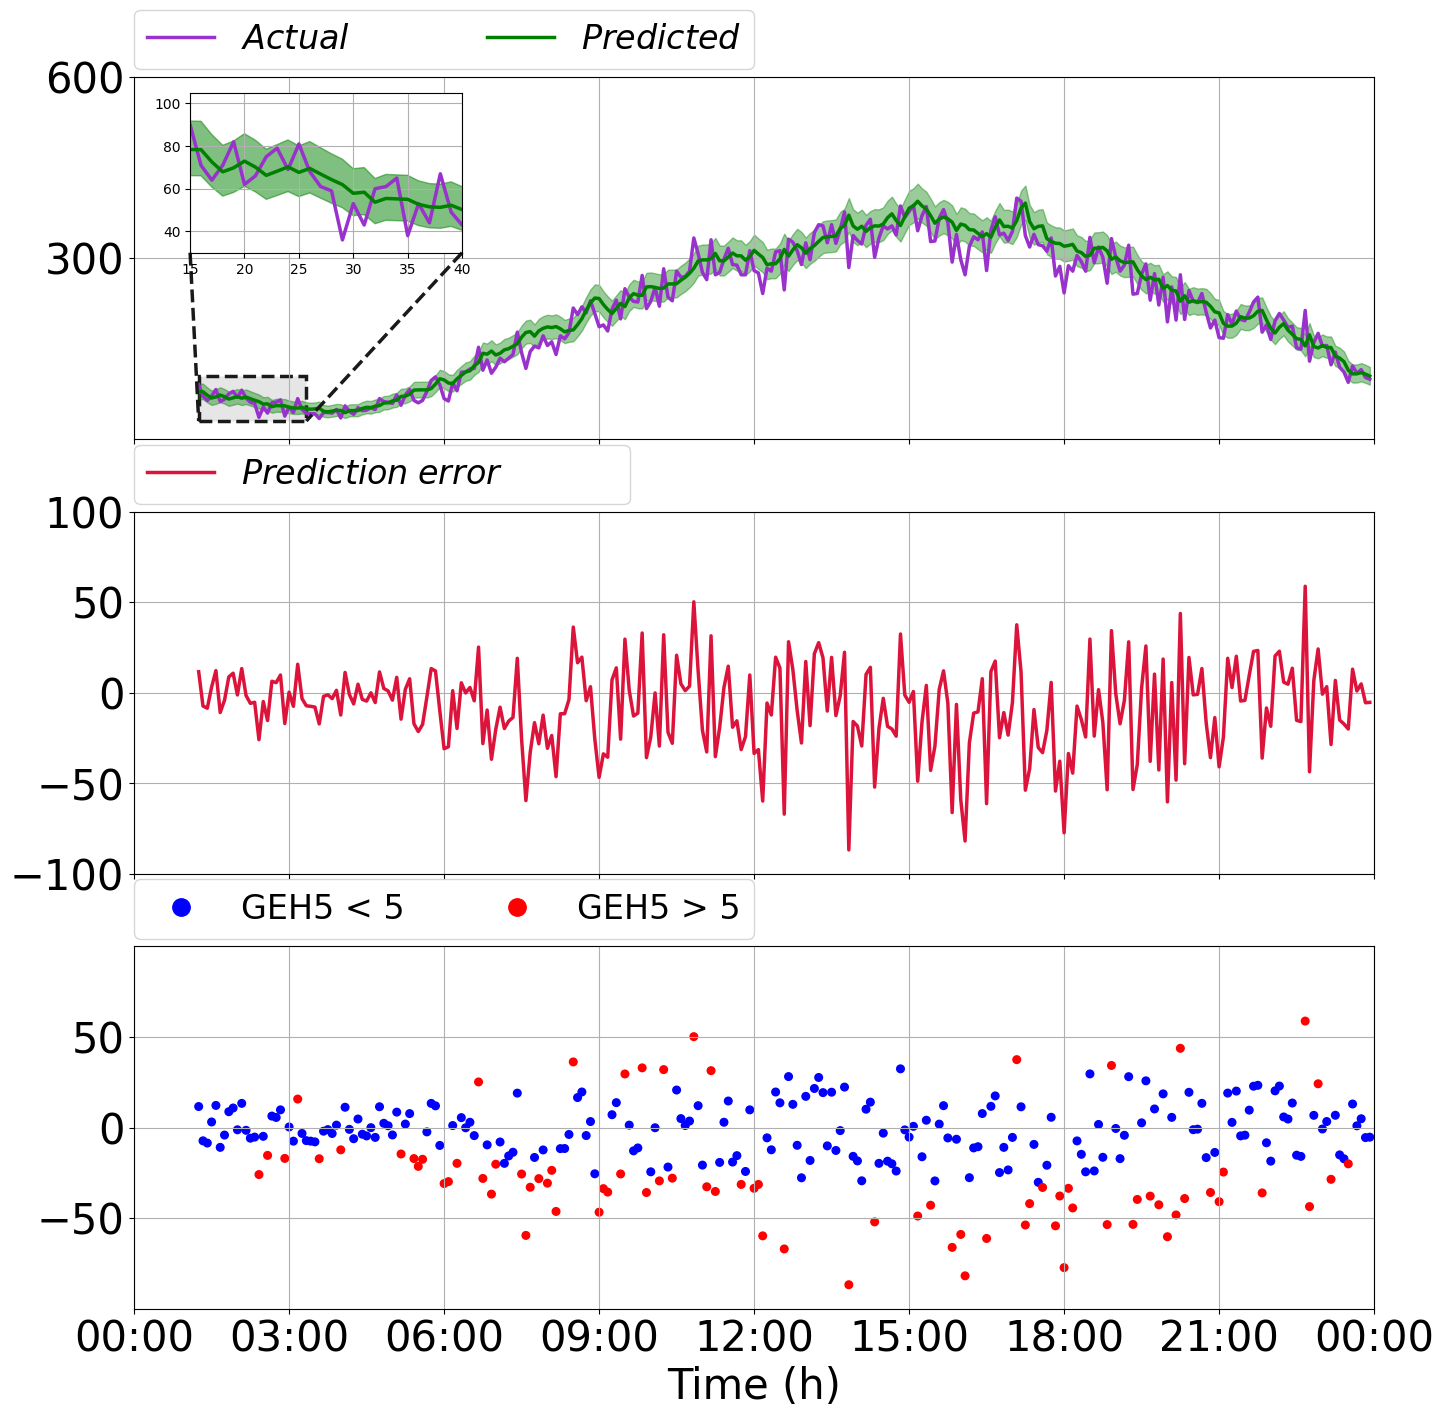

In [110]:
fig,axes = plt.subplots(nrows=3,ncols=1,figsize=(16,16))


# 1 Prediction plot
axes2 = fig.add_axes([0.16, 0.77, 0.17, 0.1]) # Smaller figure
axes2.plot(yv5, lw=2.5, label=r'$Actual$', color='darkorchid')
axes2.fill_between(x_a, lst1, lst2, alpha = .5, color = 'green')
axes2.plot(test_predictions5, lw=2.5, label=r'$Predicted$', color='green')
axes2.set_xlim(15,40)
axes2.set_ylim(30,105)
axes2.grid()
mark_inset(axes[0], axes2, loc1=3, loc2=4, fc="0.9", ec="0.1", ls='--', lw=2.5)

axes[0].plot(yv5, lw=2.5, label=r'$Actual$', color='darkorchid')
axes[0].fill_between(x_a, lst1, lst2, alpha = .4, color = 'green')
axes[0].plot(test_predictions5, lw=2.5, label=r'$Predicted$', color='green')

axes[0].legend(bbox_to_anchor=(0,1.02,0.5,0.6), loc="lower left", mode="expand", borderaxespad=0, ncol=2, prop={'size': 24})
axes[0].grid()
# x
axes[0].set_xlim(0,288)
axes[0].set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes[0].set_xticklabels([])
# y
axes[0].set_ylim(0,600)
# axes[0].set_ylabel('Flow (veh/5-Min)', fontsize=30)
axes[0].yaxis.set_major_locator(MaxNLocator(nbins=2, prune='lower'))
axes[0].yaxis.set_label_coords(-0.07,-0.1)



# 2 Error plot
axes[1].plot((yv5-test_predictions5), lw=2.5, label=r'$Prediction \; error$', color='crimson')
axes[1].legend(bbox_to_anchor=(0,1.02,0.4,0.6), loc="lower left", mode="expand", borderaxespad=0, ncol=2, prop={'size': 24})
axes[1].grid()
# x
axes[1].set_xlim(0,288)
axes[1].set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes[1].set_xticklabels([])
#y
axes[1].set_ylim(-100, 100)



# 3 GEH5 plot
axes[2].grid()
axes[2].scatter(x1[:288],(yv5-test_predictions5), s=30, c=col1)
line1, = axes[2].plot(0, 0, marker="o", markersize=0.025, markeredgecolor="blue", 
                      markerfacecolor="blue", label='GEH5 < 5', ls="None")
line2, = axes[2].plot(0, 0, marker="o", markersize=0.025, markeredgecolor="red", 
                      markerfacecolor="red", label='GEH5 > 5', ls="None")
axes[2].legend(handles=[line1, line2], markerscale=500, bbox_to_anchor=(0,1.02,0.5,0.1), 
               loc="lower left", mode="expand", borderaxespad=0, ncol=2, prop={'size': 24})
# x
axes[2].set_xlim(0,288)
axes[2].set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes[2].set_xticklabels([])
# y
axes[2].yaxis.set_major_locator(MaxNLocator(nbins=4, prune='both', steps=[5]))
# axes[2].set_ylabel('GEH', fontsize=30)
axes[2].set_ylim(-100, 100)
axes[2].yaxis.set_label_coords(-0.07,0.5)
axes[2].set_xticklabels(['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00','00:00'], fontsize=30)
axes[2].set_xlabel('Time (h)', fontsize=30)

axes[0].tick_params(axis='y', labelsize= 30)
axes[1].tick_params(axis='y', labelsize= 30)
axes[2].tick_params(axis='y', labelsize= 30)
# plt.xticks(fontsize= 20)
# plt.yticks(fontsize= 20)

In [111]:
len(GEH1[GEH1>6])/len(GEH1)

0.2777777777777778

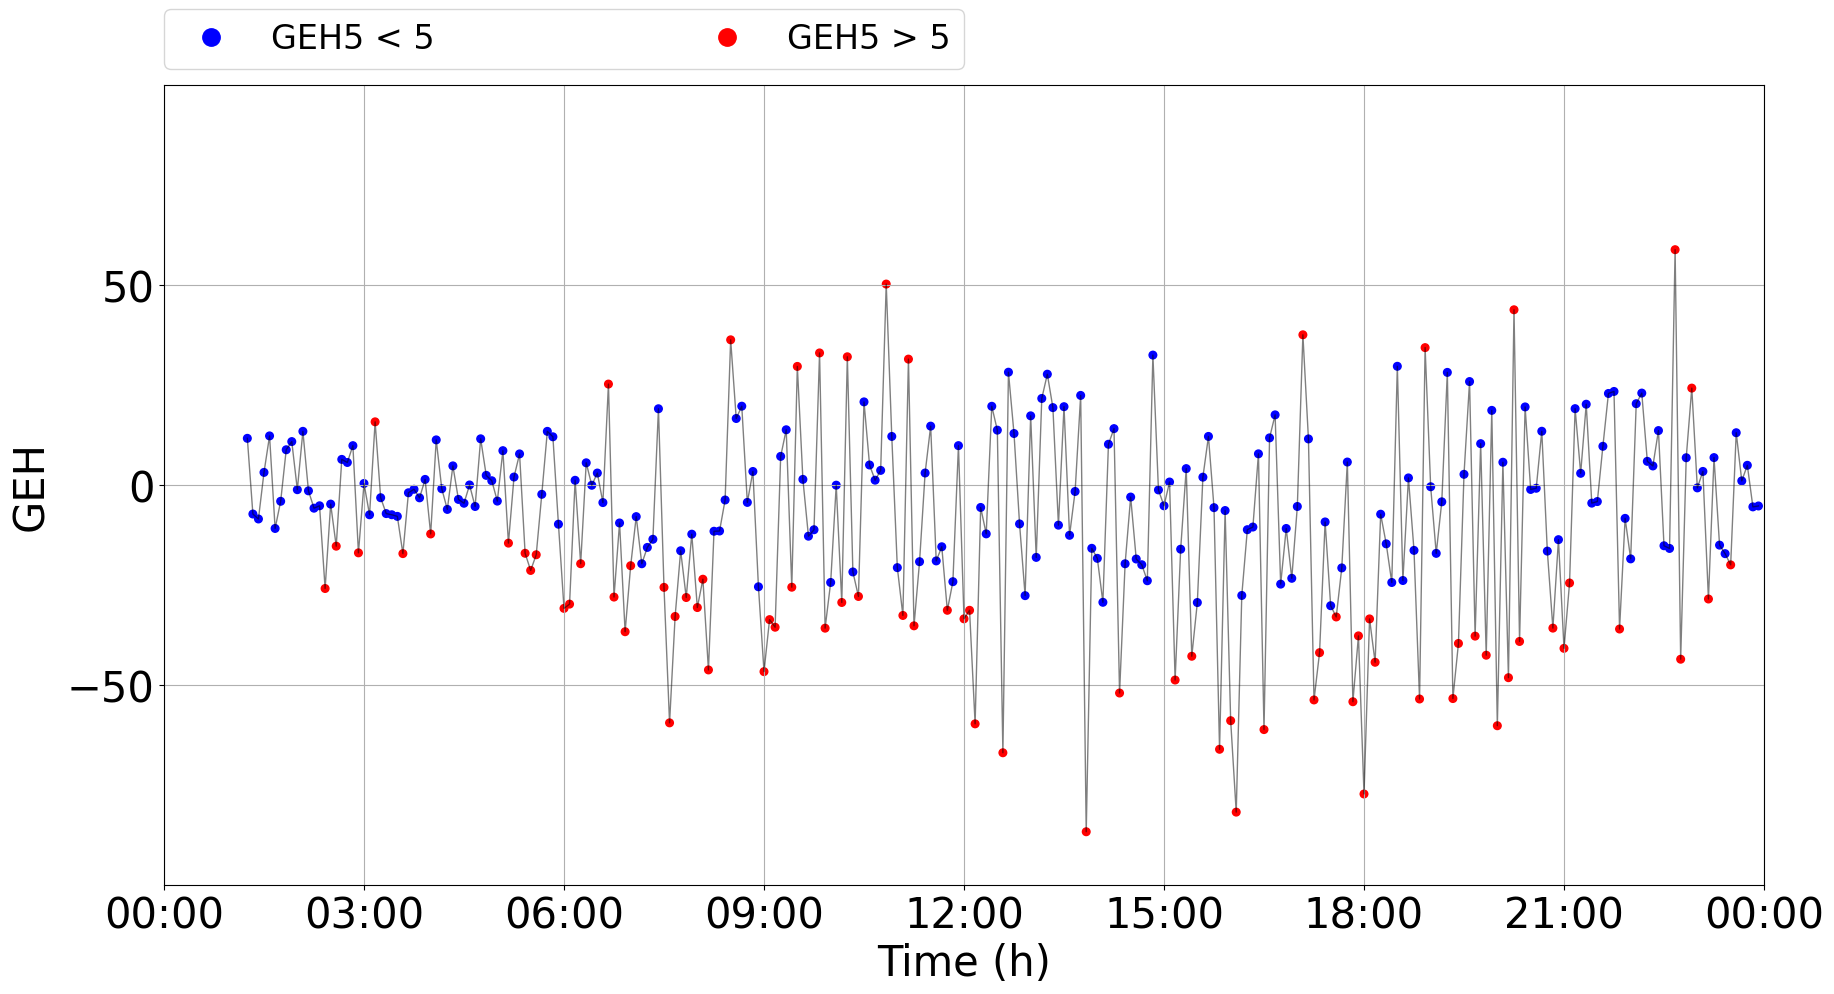

In [112]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=(16,8))

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# GEH5 plot
axes.grid()
axes.plot((yv5-test_predictions5), lw=1, color='black', alpha=0.5)
axes.scatter(x1[:288],(yv5-test_predictions5), s=30, c=col1)
line1, = axes.plot(0, 0, marker="o", markersize=0.025, markeredgecolor="blue", 
                      markerfacecolor="blue", label='GEH5 < 5', ls="None")
line2, = axes.plot(0, 0, marker="o", markersize=0.025, markeredgecolor="red", 
                      markerfacecolor="red", label='GEH5 > 5', ls="None")
axes.legend(handles=[line1, line2], markerscale=500, bbox_to_anchor=(0,1.02,0.5,0.1), 
               loc="lower left", mode="expand", borderaxespad=0, ncol=2, prop={'size': 24})
# x
axes.set_xlim(0,288)
axes.set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes.set_xticklabels([])
# y
axes.yaxis.set_major_locator(MaxNLocator(nbins=4, prune='both', steps=[5]))
axes.set_ylabel('GEH', fontsize=30)
axes.set_ylim(-100, 100)
axes.yaxis.set_label_coords(-0.07,0.5)
axes.set_xticklabels(['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00','00:00'], fontsize=30)
axes.set_xlabel('Time (h)', fontsize=30)
axes.tick_params(axis='y', labelsize= 30)

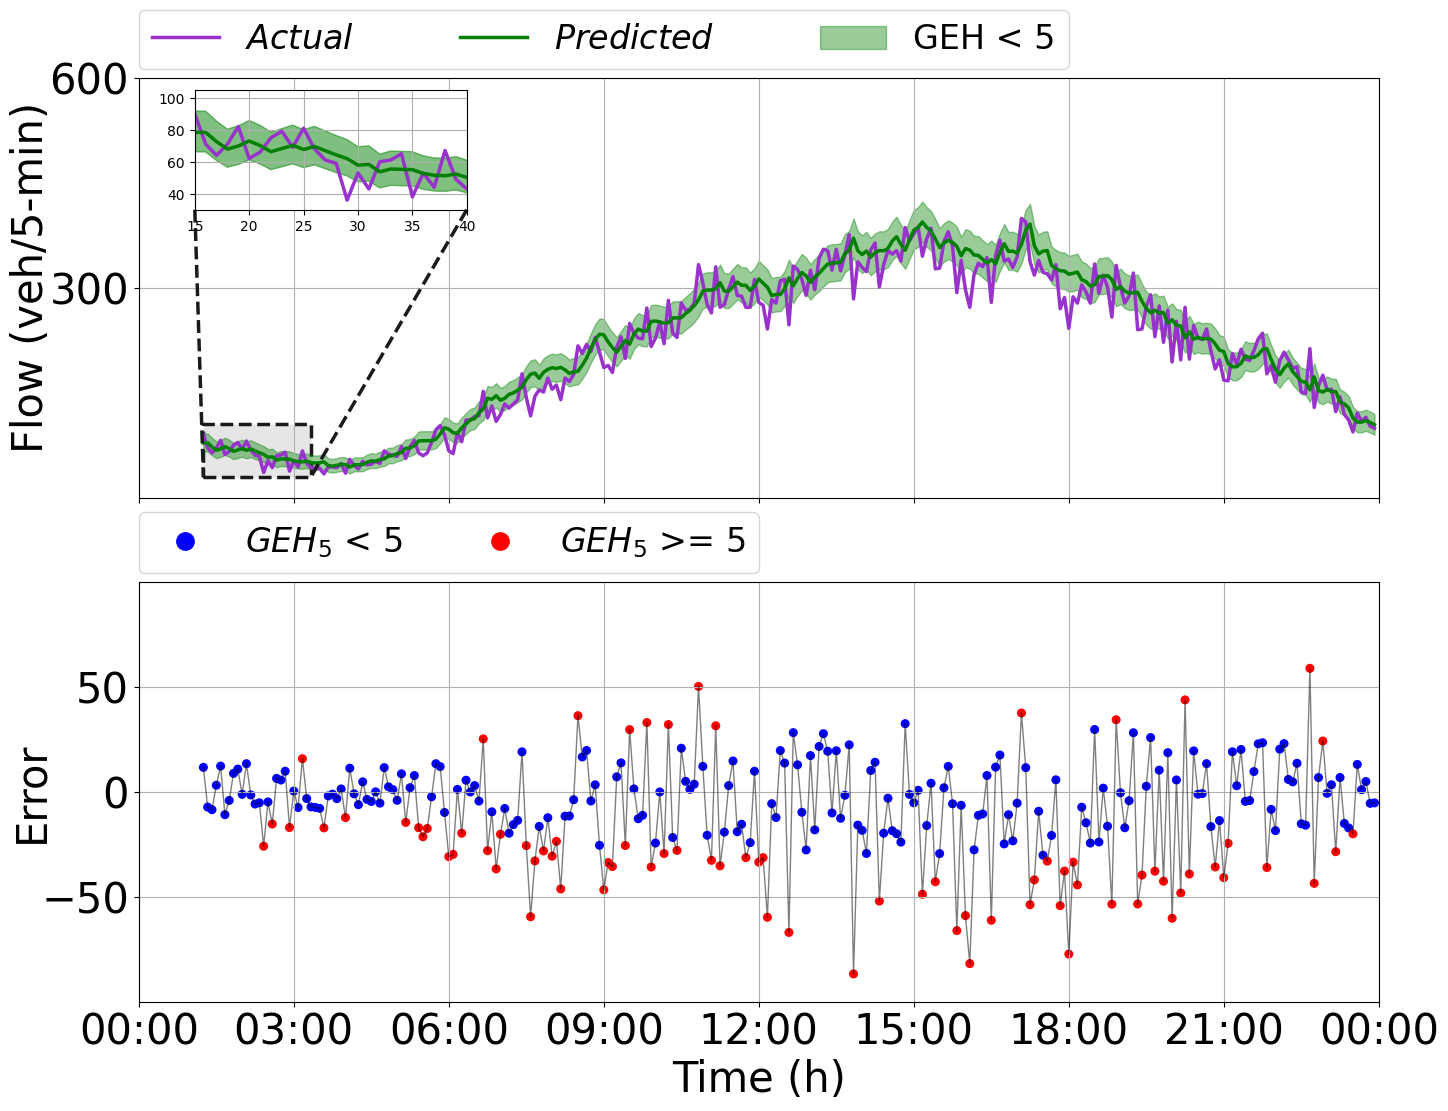

In [113]:
fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(16,12))


# 1 Prediction plot
axes2 = fig.add_axes([0.16, 0.77, 0.17, 0.1]) # Smaller figure
axes2.plot(yv5, lw=2.5, label=r'$Actual$', color='darkorchid')
axes2.fill_between(x_a, lst1, lst2, alpha = .5, color = 'green')
axes2.plot(test_predictions5, lw=2.5, label=r'$Predicted$', color='green')
axes2.set_xlim(15,40)
axes2.set_ylim(30,105)
axes2.grid()
mark_inset(axes[0], axes2, loc1=3, loc2=4, fc="0.9", ec="0.1", ls='--', lw=2.5)

axes[0].plot(yv5, lw=2.5, label=r'$Actual$', color='darkorchid')
axes[0].plot(test_predictions5, lw=2.5, label=r'$Predicted$', color='green')
axes[0].fill_between(x_a, lst1, lst2, alpha = .4, color = 'green', label="GEH < 5")

axes[0].legend(bbox_to_anchor=(0,1.02,0.75,0.6), loc="lower left", mode="expand", borderaxespad=0, ncol=3, prop={'size': 24})
axes[0].grid()

# x
axes[0].set_xlim(0,288)
axes[0].set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes[0].set_xticklabels([])
# y
axes[0].set_ylim(0,600)
axes[0].set_ylabel('Flow (veh/5-min)', fontsize=30)
axes[0].yaxis.set_major_locator(MaxNLocator(nbins=2, prune='lower'))
axes[0].yaxis.set_label_coords(-0.07, 0.525)
axes[0].tick_params(axis='y', labelsize= 30)

# 2 GEH5 plot
axes[1].grid()
axes[1].plot((yv5-test_predictions5), lw=1, color='black', alpha=0.5)
axes[1].scatter(x1[:288],(yv5-test_predictions5), s=30, c=col1)
line1, = axes[1].plot(0, 0, marker="o", markersize=0.025, markeredgecolor="blue", 
                      markerfacecolor="blue", label='$GEH_{5}$ < 5', ls="None")
line2, = axes[1].plot(0, 0, marker="o", markersize=0.025, markeredgecolor="red", 
                      markerfacecolor="red", label='$GEH_{5}$ >= 5', ls="None")
axes[1].legend(handles=[line1, line2], markerscale=500, bbox_to_anchor=(0,1.02,0.5,0.1), 
               loc="lower left", mode="expand", borderaxespad=0, ncol=2, prop={'size': 24})
# x
axes[1].set_xlim(0,288)
axes[1].set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes[1].set_xticklabels([])
# y
axes[1].yaxis.set_major_locator(MaxNLocator(nbins=4, prune='both', steps=[5]))
axes[1].set_ylabel('Error', fontsize=30)
axes[1].set_ylim(-100, 100)
axes[1].yaxis.set_label_coords(-0.07,0.5)
axes[1].set_xticklabels(['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00','00:00'], fontsize=30)
axes[1].set_xlabel('Time (h)', fontsize=30)
axes[1].tick_params(axis='y', labelsize= 30)

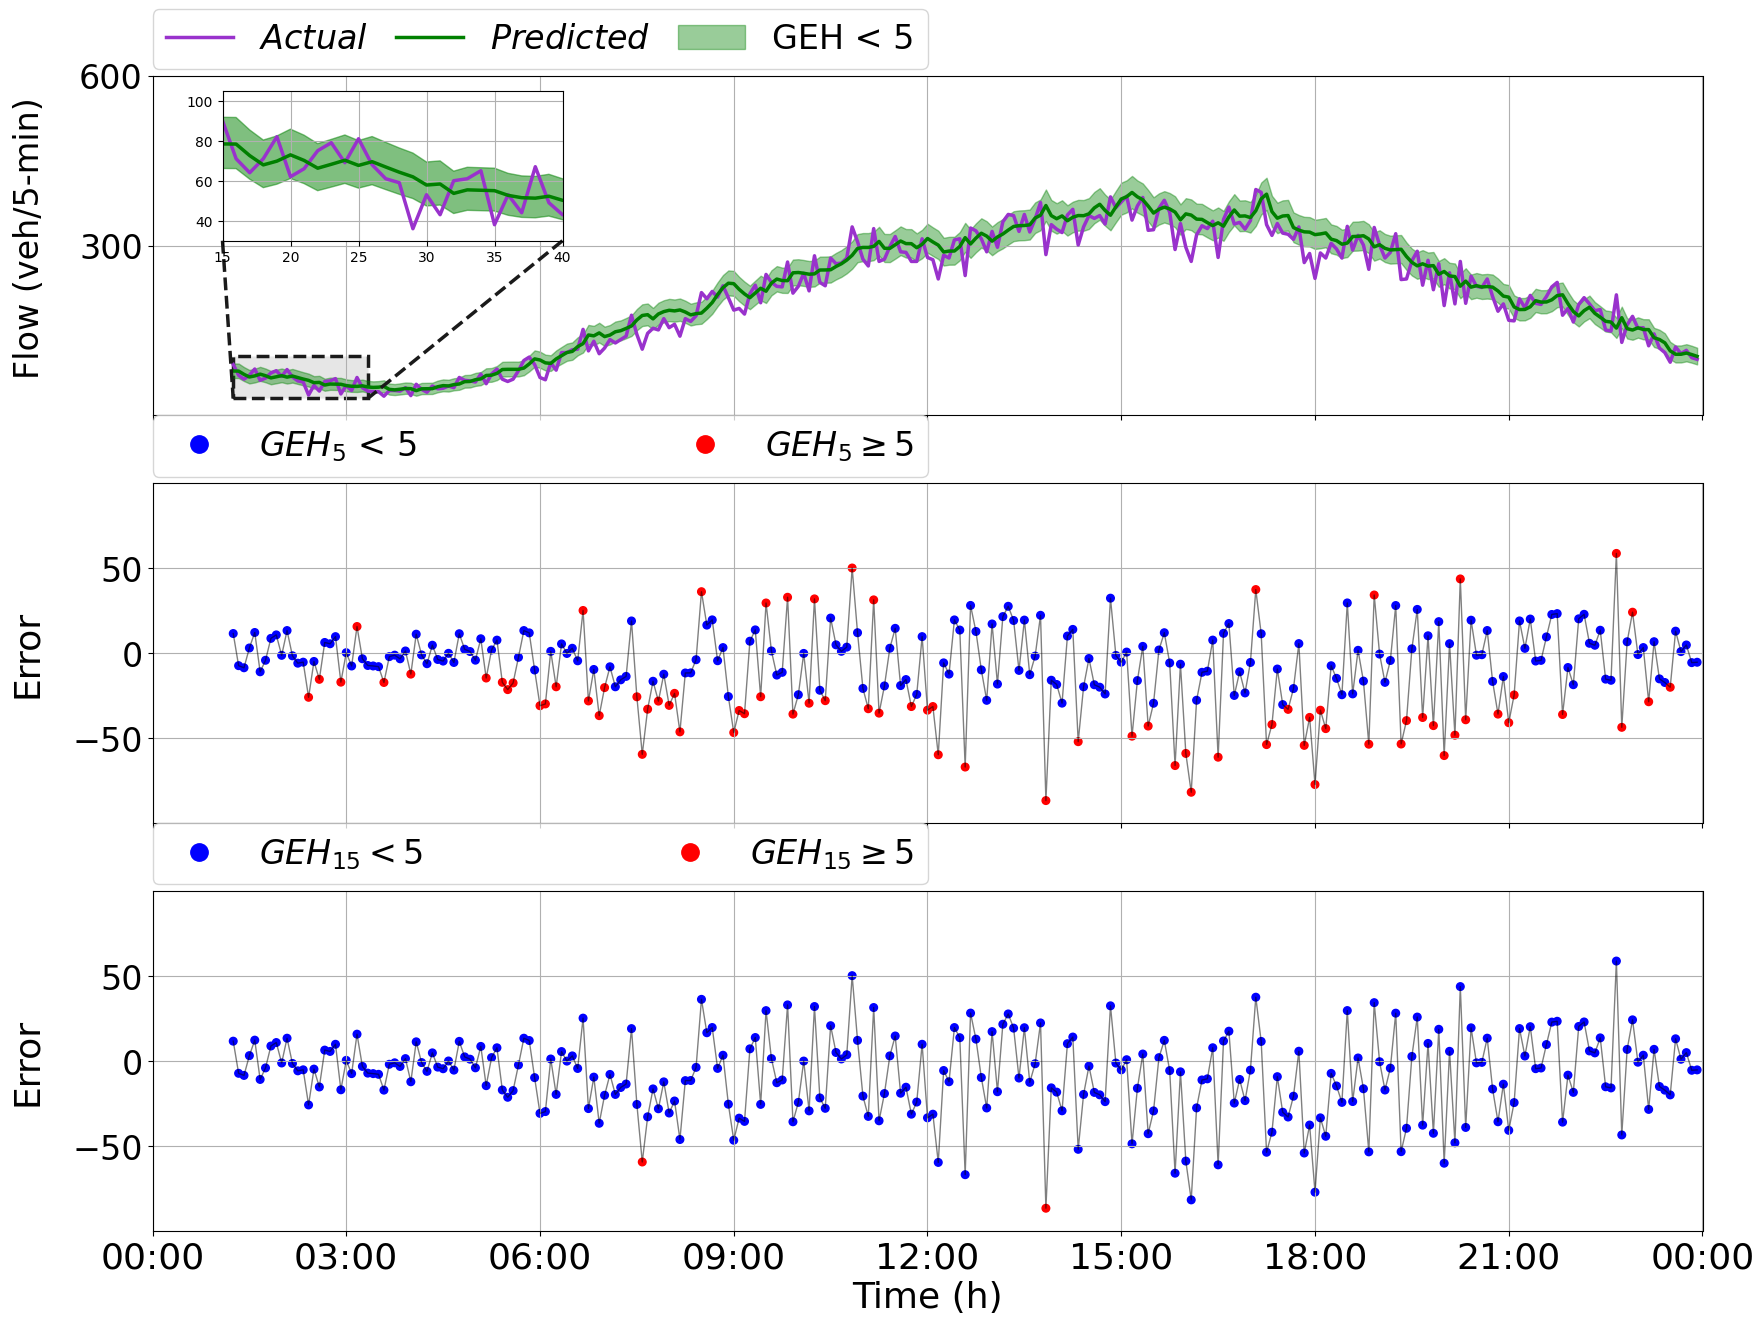

In [114]:
fig,axes = plt.subplots(nrows=3,ncols=1,figsize=(20,15))


# 1 Prediction plot
axes2 = fig.add_axes([0.16, 0.77, 0.17, 0.1]) # Smaller figure
axes2.plot(yv5, lw=2.5, label=r'$Actual$', color='darkorchid')
axes2.fill_between(x_a, lst1, lst2, alpha = .5, color = 'green')
axes2.plot(test_predictions5, lw=2.5, label=r'$Predicted$', color='green')
axes2.set_xlim(15,40)
axes2.set_ylim(30,105)
axes2.grid()
mark_inset(axes[0], axes2, loc1=3, loc2=4, fc="0.9", ec="0.1", ls='--', lw=2.5)

axes[0].plot(yv5, lw=2.5, label=r'$Actual$', color='darkorchid')
axes[0].plot(test_predictions5, lw=2.5, label=r'$Predicted$', color='green')
axes[0].fill_between(x_a, lst1, lst2, alpha = .4, color = 'green', label="GEH < 5")

axes[0].legend(bbox_to_anchor=(0,1.02,0.5,0.6), loc="lower left", mode="expand", borderaxespad=0, ncol=3, prop={'size': 24})
axes[0].grid()
# x
axes[0].set_xlim(0,288)
axes[0].set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes[0].set_xticklabels([])
# y
axes[0].set_ylim(0,600)
axes[0].set_ylabel('Flow (veh/5-min)', fontsize=24)
axes[0].yaxis.set_major_locator(MaxNLocator(nbins=2, prune='lower'))
axes[0].yaxis.set_label_coords(-0.069, 0.525)
axes[0].tick_params(axis='y', labelsize= 24)

# 2 GEH5 plot
axes[1].grid()
axes[1].plot((yv5-test_predictions5), lw=1, color='black', alpha=0.5)
axes[1].scatter(x1[:288],(yv5-test_predictions5), s=30, c=col1)
line1, = axes[1].plot(0, 0, marker="o", markersize=0.025, markeredgecolor="blue", 
                      markerfacecolor="blue", label='$GEH_{5}$ < 5', ls="None")
line2, = axes[1].plot(0, 0, marker="o", markersize=0.025, markeredgecolor="red", 
                      markerfacecolor="red", label='$GEH_{5} \geq 5$', ls="None")
axes[1].legend(handles=[line1, line2], markerscale=500, bbox_to_anchor=(0,1.02,0.5,0.1), 
               loc="lower left", mode="expand", borderaxespad=0, ncol=2, prop={'size': 24})
# x
axes[1].set_xlim(0,288)
axes[1].set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes[1].set_xticklabels([])
# y
axes[1].yaxis.set_major_locator(MaxNLocator(nbins=4, prune='both', steps=[5]))
axes[1].set_ylabel('Error', fontsize=26)
axes[1].set_ylim(-100, 100)
axes[1].yaxis.set_label_coords(-0.07,0.5)
# Set the ytick label size for axes[1]
axes[1].tick_params(axis='y', labelsize=24)



# 3 GEH15 plot
axes[2].grid()
axes[2].plot((yv5-test_predictions5), lw=1, color='black', alpha=0.5)
axes[2].scatter(x1[:288],(yv5-test_predictions5), s=30, c=col2)
line1, = axes[1].plot(0, 0, marker="o", markersize=0.025, markeredgecolor="blue", 
                      markerfacecolor="blue", label='$GEH_{15} < 5$', ls="None")
line2, = axes[1].plot(0, 0, marker="o", markersize=0.025, markeredgecolor="red", 
                      markerfacecolor="red", label='$GEH_{15} \geq 5$', ls="None")
axes[2].legend(handles=[line1, line2], markerscale=500, bbox_to_anchor=(0,1.02,0.5,0.1), 
               loc="lower left", mode="expand", borderaxespad=0, ncol=2, prop={'size': 24})

# x
axes[2].set_xlim(0,288)
axes[2].set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes[2].set_xticklabels([])
# y
axes[2].yaxis.set_major_locator(MaxNLocator(nbins=4, prune='both', steps=[5]))
axes[2].set_ylabel('Error', fontsize=26)
axes[2].set_ylim(-100, 100)
axes[2].yaxis.set_label_coords(-0.07,0.5)

axes[2].set_xticklabels(['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00','00:00'], fontsize=26)
axes[2].set_xlabel('Time (h)', fontsize= 26)
axes[2].tick_params(axis='y', labelsize= 24)